ECE 4424 Final Project - Ben Scoppa

In [12]:
import os
import pandas as pd
import random
random.seed(1)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.layers import TimeDistributed, Bidirectional, Dropout, RepeatVector
from keras.optimizers import Adam

In [13]:
"""
Note: put the Stocks Data folder into drive with the ipynb and change
folder_path to the data location.
"""

from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/ECE4424_Final_Project/Stocks'
print(os.listdir(folder_path))

def load_sampled_data(folder_path, sample_size=100):
    all_files = os.listdir(folder_path)
    sampled_files = random.sample(all_files, sample_size)
    all_data = []

    for filename in sampled_files:
        file_path = os.path.join(folder_path, filename)
        if os.path.getsize(file_path) > 0:
            try:
                stock_id = filename.split('.')[0]
                file_path = os.path.join(folder_path, filename)
                data = pd.read_csv(file_path)
                data['Stock_ID'] = stock_id
                all_data.append(data)
            except pd.errors.EmptyDataError:
                continue
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

data = load_sampled_data(folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['sunw.us.txt', 'stwd.us.txt', 'supv.us.txt', 'stz-b.us.txt', 'sui.us.txt', 'sun.us.txt', 'swks.us.txt', 'swn.us.txt', 'svvc.us.txt', 'swk.us.txt', 'susc.us.txt', 'svm.us.txt', 'swch.us.txt', 'svt.us.txt', 'swnc.us.txt', 'swp.us.txt', 'swm.us.txt', 'swin.us.txt', 'svbi.us.txt', 'swir.us.txt', 'sva.us.txt', 'svra.us.txt', 'svu.us.txt', 'swj.us.txt', 'swx.us.txt', 'sxe.us.txt', 'syn.us.txt', 'sybx.us.txt', 'synl.us.txt', 'syna.us.txt', 'swz.us.txt', 'sybt.us.txt', 'syf.us.txt', 'symx.us.txt', 'symc.us.txt', 'sxc.us.txt', 'syk.us.txt', 'syke.us.txt', 'sxt.us.txt', 'sxi.us.txt', 'sxcp.us.txt', 'sync.us.txt', 'syy.us.txt', 'syt.us.txt', 't.us.txt', 'tait.us.txt', 'synt.us.txt', 'syx.us.txt', 'tanni.us.txt', 'syrs.us.txt', 'tal.us.txt', 'tact.us.txt', 'taco.us.txt', 'tacow.us.txt', 'ta.us.txt', 'sypr.us.txt', 'taho.us.txt', 'tanh.us.txt', 'tail.us.txt', 'tac.us.txt

In [14]:
# function for calculating the mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true, dtype=np.float64), np.array(y_pred, dtype=np.float64)
    n_samples = len(y_true)
    sum_mape = 0

    for i in range(0, n_samples):
        end_idx = min(i+1, n_samples)
        batch_y_true = y_true[i:end_idx]
        batch_y_pred = y_pred[i:end_idx]

        sum_mape += np.mean(np.abs((batch_y_true - batch_y_pred) / batch_y_true)) * 100

    return sum_mape / n_samples

In [15]:
# function for determining directional accuracy
def directional_accuracy(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    true_directions = np.sign(y_true[1:] - y_true[:-1])
    pred_directions = np.sign(y_pred[1:] - y_pred[:-1])
    directions = true_directions == pred_directions
    return np.mean(directions) * 100

In [16]:
# extract the day, month and year
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# sort data by stock id and date
data.sort_values(by=['Stock_ID', 'Date'], inplace=True)

# copy of data for lstm
lstm_data = data

# group by stock id
grouped = data.groupby('Stock_ID')

def process_group(group):
    # add a exponential moving average closing price
    group['EMA_Close'] = group['Close'].ewm(span=3, adjust=False).mean().shift(1)
    group.dropna(inplace=True)
    return group

# process each group
data = grouped.apply(process_group)

# extract features
X = data[['Open', 'Year', 'Month', 'Day', 'EMA_Close']]
y = data['Close']

# split into test and train data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Root Mean Squared Error: 0.6657931177640382
Mean Absolute Error: 0.37385414396176564
Mean Absolute Percentage Error: 1.8845421491913836
Directional Accruacy: 53.36900295273406


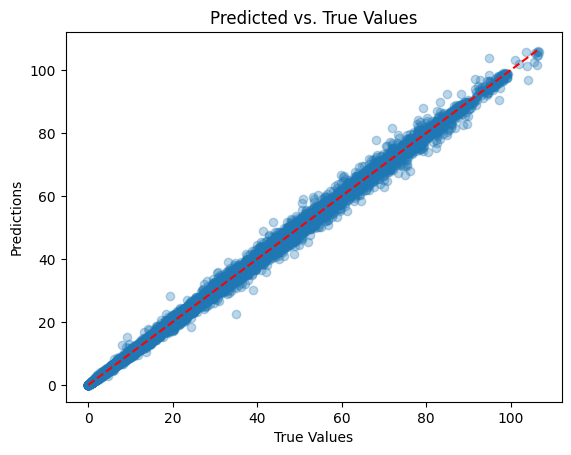

In [6]:
# linear regression with principla componet analysis
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('linear_regression', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# output validation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Squared Error:', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean Absolute Percentage Error:', mape)
direction_acc = directional_accuracy(y_test, y_pred)
print('Directional Accruacy:', direction_acc)

# Scatter plot of Predicted vs. True values
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. True Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

Root Mean Squared Error: 0.6160195351499248
Mean Absolute Error: 0.34289320258887046
Mean Absolute Percentage Error: 1.6736752804981816
Directional Accruacy: 55.34711275891926


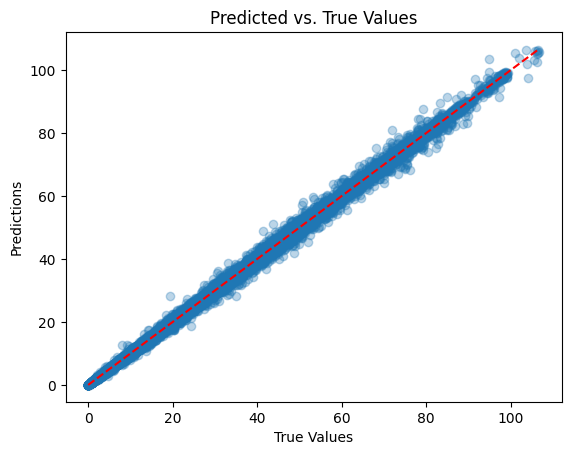

In [7]:
# support vector machine
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='linear'))
])

svr_pipeline.fit(X_train, y_train)
y_pred = svr_pipeline.predict(X_test)

# output validation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Squared Error:', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean Absolute Percentage Error:', mape)
direction_acc = directional_accuracy(y_test, y_pred)
print('Directional Accruacy:', direction_acc)

# Scatter plot of Predicted vs. True values
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. True Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

In [17]:
# add a feature for relative strength index
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

# add reative strength index and moving average
lstm_data['MA_10'] = lstm_data['Close'].rolling(window=10).mean().shift(1)
lstm_data['MA_20'] = lstm_data['Close'].rolling(window=20).mean().shift(1)
lstm_data['RSI'] = compute_RSI(lstm_data['Close']).shift(1)
lstm_data.dropna(inplace=True)

# process the data
# the input X contains list of each feature for the previous ten days
# the target y is the next days closing price
def preprocess_lstm(data, n_steps):
    X, y = [], []
    feature_indices = [data.columns.get_loc(col) for col in features]
    close_index = data.columns.get_loc('Close')

    for i in range(len(data) - n_steps - 1):
        end_ix = i + n_steps
        if end_ix >= len(data) - 1:
            break

        seq_x = data.iloc[i:end_ix, feature_indices].values
        seq_y = data.iloc[end_ix + 1, close_index]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

# Normalize the data
features = ['Open', 'High', 'Low', 'Volume', 'MA_10', 'RSI', 'Close']
scaler = StandardScaler()
lstm_data[features] = scaler.fit_transform(lstm_data[features])

# process data and slipt into train and test
n_steps = 10
n_features = 7
X, y = preprocess_lstm(lstm_data, n_steps)
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# reshape input
X_train_reshaped = X_train.reshape((X_train.shape[0], n_steps, n_features))


In [18]:
# create the combination cnn lstm model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)),
    MaxPooling1D(pool_size=2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

# train the model
history = model.fit(X_train_reshaped, y_train, epochs=15, batch_size=32, verbose=1, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 8, 64)             1408      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 4, 100)            66000     
                                                                 
 dropout_2 (Dropout)         (None, 4, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

1174/1174 [==============================] - 6s 5ms/step
Root Mean Squared Error: 0.023334860359305733
Mean Absolute Error: 0.01254390177159795
Mean Absolute Percentage Error: 28.699513608001524
Directional Accuracy: 47.9491823363341


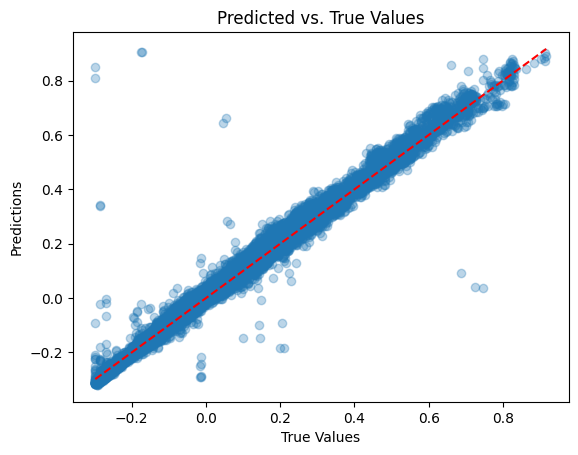

In [22]:
# reshape array
X_test_reshaped = X_test.reshape((X_test.shape[0], n_steps, 7))

# predict using test data
y_pred = model.predict(X_test).squeeze()

# validation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Squared Error:', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean Absolute Percentage Error:', mape)
direction_acc = directional_accuracy(y_test, y_pred)
print('Directional Accuracy:', direction_acc)

# Scatter plot of Predicted vs. True values
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. True Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()